# Pyspark Random Forest Model to Predict Graduation Rates
### Thomeka Watkins (sec 1)
### Seth Brown (sec 1)
### John Custer (sec 1)
### Frank Guo (sec 1)
### Milan (Deratu) Dinku (sec 2)
### Christopher Carlevato (sec 2)
##### source: https://www.silect.is/blog/2019/4/2/random-forest-in-spark-ml

In [1]:
import os
os.getcwd()

'C:\\Users\\chris\\MSBA\\Big Data'

In [2]:
os.chdir('C:\sparkcourse')

In [3]:
os.getcwd()

'C:\\sparkcourse'

In [4]:
#!pip install pyspark

In [5]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd

##### Create a Spark Context and read in CollegeB.csv as a pyspark dataframe.
*Note: CollegeB.csv has college name taken out, the private school column was changed to 0/1 using if formula in excel, and Grad_Rate column was changed 
"label" in excel.

In [6]:
sc = SparkContext('local','example')  # if using locally
sql_sc = SQLContext(sc)

pandas_df = pd.read_csv('CollegeB.csv')  # assuming the file contains a header 
pandas_df = pandas_df.drop(['Unnamed: 0'], axis=1) #get rid of unnecessary column which contains college name

s_df = sql_sc.createDataFrame(pandas_df)

In [7]:
#s_df.show(10)

#### Spark's ML RF requires that features are formated as a single vector:

In [8]:
from pyspark.ml.feature import VectorAssembler

feature_list = []
for col in s_df.columns:
    if col == 'label': #what we are trying to predict (grad rate)
        continue
    else:
        feature_list.append(col)

assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

#### Only inputs for RF are the label (what we are predicting) and the features:

In [9]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="label", featuresCol="features")

#### Import ML pipeline:

In [10]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, rf])

#### Hyperparameter grid to optimize number of trees and branches:
*Note: Used Spark's default setting for parameters not specified in grid

In [11]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

#### Use 3-fold cross validation to evaluate the model and hyperparameters:

In [12]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [13]:
(trainingData, testData) = s_df.randomSplit([0.8, 0.2])

#### Run the model:

In [14]:
cvModel = crossval.fit(trainingData)

In [15]:
predictions = cvModel.transform(testData)

#### Evaluate the model:

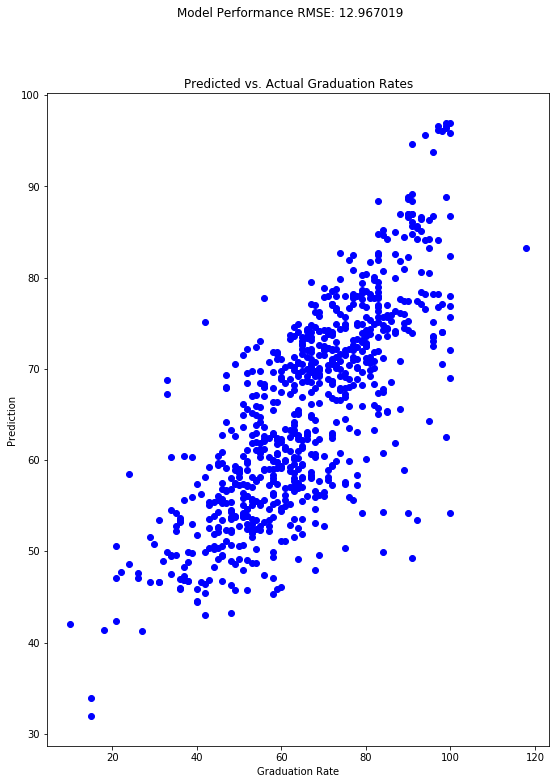

In [48]:
import matplotlib.pyplot as plt

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(s_df)

rfResult = rfPred.toPandas()

plt.figure(figsize=(9,12))
plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Graduation Rate')
plt.ylabel('Prediction')
plt.title("Predicted vs. Actual Graduation Rates")
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

#### Feature importance: 

Text(0.5, 1.0, 'Feature Importances')

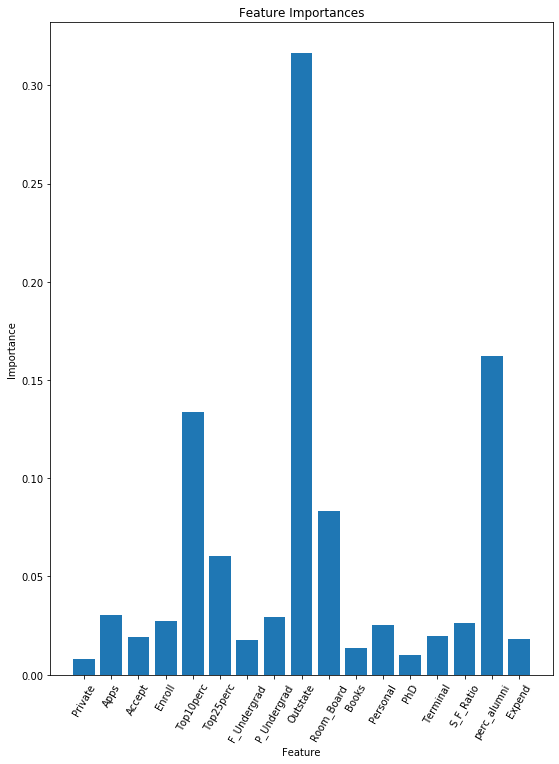

In [45]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances


x_values = list(range(len(important_features_list)))

plt.figure(figsize=(9,12))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=60)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [46]:
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

numTrees -  10
maxDepth -  5
